In [1]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [2]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

import my_secrets as sc
import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf


import os
if my_run == "azure":
    if not os.path.exists(cf.HUGGING_CACHE):
        os.mkdir(cf.HUGGING_CACHE)
    os.environ["TRANSFORMERS_CACHE"] = cf.HUGGING_CACHE

import pandas as pd
# setup environment GEITje-7B Finetuning
# - pip install torch
# - pip install datasets
# - pip install transformers
# - pip install trl
# - pip install accelerate (restart after)
# - switch device_map='auto' to avaoid memory error

# - pip install sentencepiece
# - pip install jupyter
# - pip install protobuf 



### Notebook Overview
Goal: analyse the baselines, understand why they work so well

In [3]:
logreg = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/LogisticRegressionpredictions.pkl")
linsvc = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/LinearSVCpredictions.pkl")
nb = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/MultinomialNBpredictions.pkl")

overview = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/overview.pkl")

predictions = pd.concat([logreg, linsvc, nb])


In [7]:
from transformers import AutoTokenizer
from collections import Counter
from sklearn.metrics import classification_report
import sys
sys.path.append('../src/') 
import prompt_template as pt
import warnings
warnings.simplefilter('ignore')


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def percentage_mistakes(count):
    return f"{round(count/1100*100,1)}%"

def mistakes(df, detailed=False):
    print('MISTAKES. INCLUDES PREDICTIONS ERRORS.')

    # select all response where the prediction was not correct
    mistakes = df.loc[df['label'] != df['prediction']]

    # groupby run_id so we get the amount of mistakes per run
    mistakes_per_run = mistakes.groupby('run_id').size().reset_index(name='count')
    mistakes_per_run['percentage of total predictions'] = mistakes_per_run['count'].apply(percentage_mistakes)
    print("Total amount of mistakes per run:")
    display(mistakes_per_run)

    # for each run get the amount of mistakes per class
    df_count_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(mistakes['run_id']):
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes per class
        class_count = dict(Counter(subdf['label']))

        # if a class is not included in mistakes, set counter to 0
        for category in pt.get_class_list():
            if category not in class_count.keys():
                class_count[category] = 0

        # add count of class to df
        df_count_class.loc[len(df_count_class)] = class_count

    # reset index to runids
    df_count_class.index = list(set(mistakes['run_id']))
    print("Amount of mistakes per class for each run:")
    display(df_count_class)

    # For each run get for each class the highest mistakes
    df_highest_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(mistakes['run_id']):
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes of runid
        count_mistakes_per_class = dict(Counter(subdf['label']))

        class_count = subdf.groupby('label')['prediction'].value_counts().reset_index(name='count')
        highest_per_class = dict()
        for label in set(class_count['label']):
            # for each class select the class for which it made the most mistakes
            highest_count_row = class_count.iloc[class_count[class_count['label'] == label]['count'].idxmax()]
            highest_per_class[label] = f"{highest_count_row['prediction']} ({highest_count_row['count']} out of {count_mistakes_per_class[label]})"

        # add to df
        df_highest_class.loc[len(df_highest_class)] = highest_per_class
    # reset index to run_id
    df_highest_class.index = list(set(mistakes['run_id']))
    print("Highest mistakes per class for each run:")
    display(df_highest_class.transpose())


def predictions_per_class(df):
    df_predictions_per_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(df['run_id']):
        subdf = df.loc[df['run_id']==run_id]
        count_predictions = dict(Counter(subdf['prediction']))
        df_predictions_per_class.loc[len(df_predictions_per_class)] = count_predictions

    df_predictions_per_class.index = list(set(df['run_id']))
    display(df_predictions_per_class.transpose())



def plot_confusion_matrix(df):
    run_ids = sorted(df['run_id'].unique())

    for i, run_id in enumerate(run_ids):
        subdf = df[df['run_id'] == run_id]
        class_labels = sorted(set(subdf['prediction']).union(set(subdf['label'])))
        class_dict = {label: idx for idx, label in enumerate(class_labels)}

        y_true = np.array([class_dict[label] for label in subdf['label']])
        y_pred = np.array([class_dict[label] for label in subdf['prediction']])

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels)))

        # Create a new figure for each confusion matrix
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for RUN_ID: {run_id}')
        plt.show()


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_avg_cos_sim(df, class1, class2):
    run_ids = sorted(list(set(df['run_id'])))
    
    for run_id in run_ids:
        subdf = df.loc[df['run_id']== run_id]

        # Example texts for each class
        class1_texts = list(subdf.loc[subdf['label']==class1]['trunc_txt'])
        class2_texts = list(subdf.loc[subdf['label']==class2]['trunc_txt'])

        # Combine all texts
        all_texts = class1_texts + class2_texts

        # Initialize TF-IDF vectorizer
        tfidf_vectorizer = TfidfVectorizer()

        # Compute TF-IDF vectors for all texts
        tfidf_vectors = tfidf_vectorizer.fit_transform(all_texts)

        # Calculate cosine similarity between all pairs of TF-IDF vectors
        cosine_similarities = cosine_similarity(tfidf_vectors)

        # Calculate average cosine similarity between texts of class 1 and class 2
        num_class1 = len(class1_texts)
        num_class2 = len(class2_texts)
        total_cosine_similarity = 0

        for i in range(num_class1):
            for j in range(num_class1, num_class1 + num_class2):
                total_cosine_similarity += cosine_similarities[i][j]

        average_cosine_similarity = total_cosine_similarity / (num_class1 * num_class2)

        print(f"{run_id}: Average cosine similarity between texts of {class1} and {class2}:", average_cosine_similarity)

def class_reports(df):
    run_ids = sorted(list(set(df['run_id'])))
    error_names = ['NoPredictionInOutput', 'MultiplePredictionErrorInFormatting','NoPredictionFormat', 'MultiplePredictionErrorInOutput']

    for run_id in run_ids:
        print(run_id)
        subdf = df.loc[df['run_id']==run_id]
        print(f"Amount of errors: {len(subdf.loc[subdf['prediction'].isin(error_names)])}")
        subdf.loc[subdf['prediction'].isin(error_names),'prediction'] = 'PredictionError'

        y_pred = subdf['prediction']
        y_true = subdf['label']
        print(classification_report(y_true, y_pred))


### Classification Reports

In [8]:
class_reports(predictions)

LinearSVC_first100_last0
Amount of errors: 0
                     precision    recall  f1-score   support

        Actualiteit       0.94      0.79      0.86       200
             Agenda       0.93      0.99      0.96       200
            Besluit       0.97      0.96      0.96       200
              Brief       0.97      0.96      0.96       200
          Factsheet       1.00      0.28      0.44       200
              Motie       0.94      0.94      0.94       200
  Onderzoeksrapport       0.56      0.95      0.71       200
         Raadsadres       0.76      0.94      0.84       200
       Raadsnotulen       1.00      0.98      0.99       200
Schriftelijke Vraag       1.00      0.94      0.97       200
         Voordracht       1.00      0.99      0.99       200

           accuracy                           0.88      2200
          macro avg       0.92      0.88      0.88      2200
       weighted avg       0.92      0.88      0.88      2200

LinearSVC_first100_last100
Amount of 

### Confusion Matrix
- LinearSVC: 200 and full text both struggle with factsheets, they mistake them for onderzoeksrapport. 200 (=70mistaken for onderzoeksrapport) more problem than full text (=46mistaken for onderzoeksrapport). Not many other mistakes. If a mistaken happens for actualiteit, then it's mostly mistaken for raadsadres, but also other classes.
- LogisticRegression: once again 200 and fulltext both struggle with factsheets, they are again mistake for onderzoeksrapport. Logistic regression (200=79; fulltext=52mistaken for onderzoeksrapport) has more trouble with this than linearSVC. If a mistaken happens for actualiteit, more so than LinearSVC, then it's mostly mistaken for raadsadres, but also other classes.
- Naive Bayes: trouble with many more classes. Especially factsheets  (200=61; fulltext=98 mistaken for onderzoeksrapport) and raadsnotulen of which none of the docs were correctly classified. Funnily enough, 200 mistakes raadsnotulen for moties (64 mistaken for moties), while fulltext mistakes them for raadsadres (86 mistaken for raadsadres). Naive Bayes is the only one (out of 3) that performs worse using 200 instead of fulltext. 

LinearSVC_first100_last0


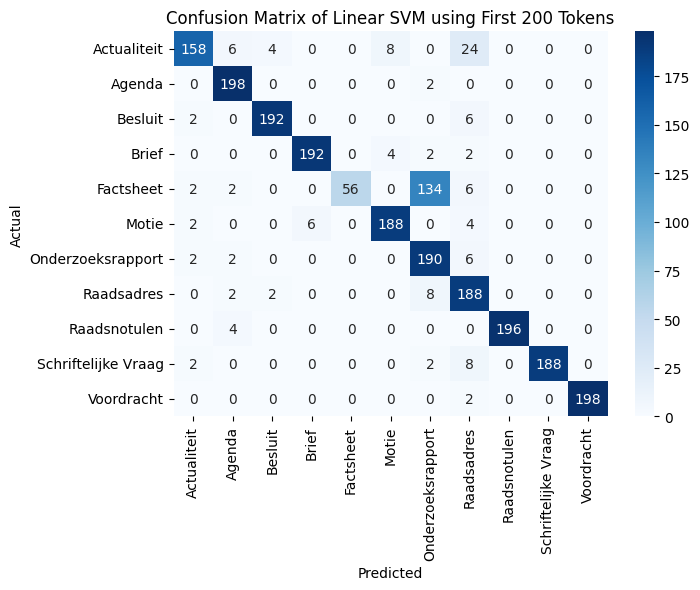

LinearSVC_first100_last100


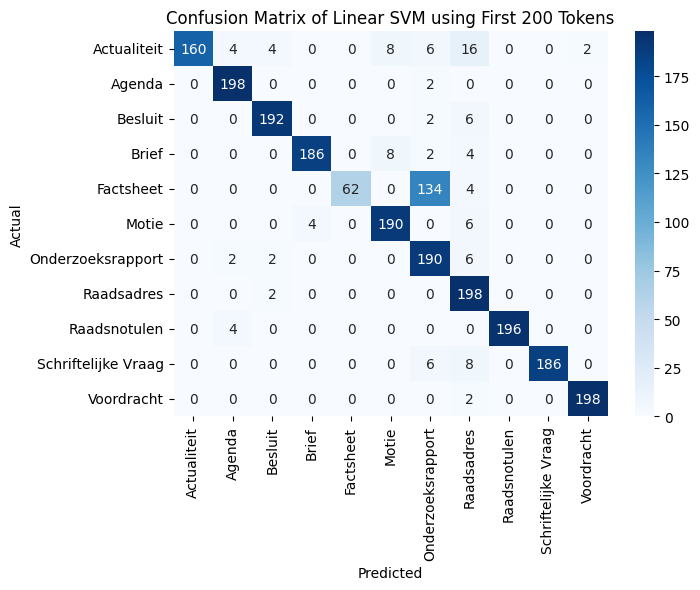

LinearSVC_first200_last0


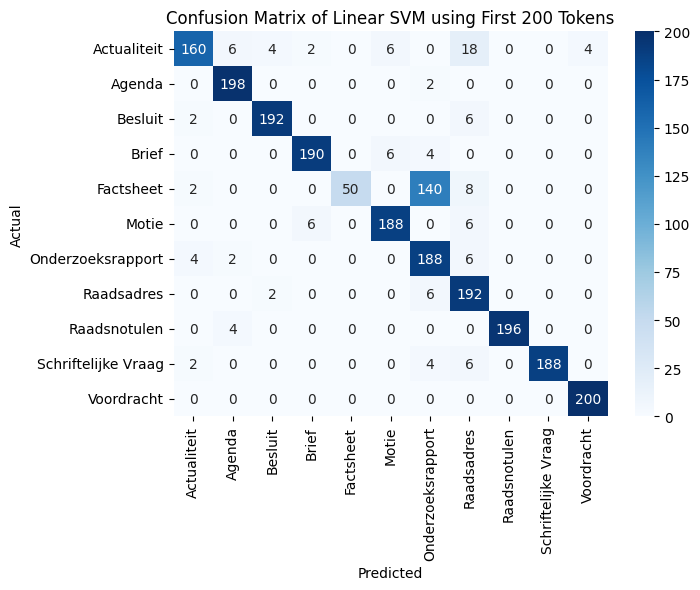

LinearSVC_fulltext


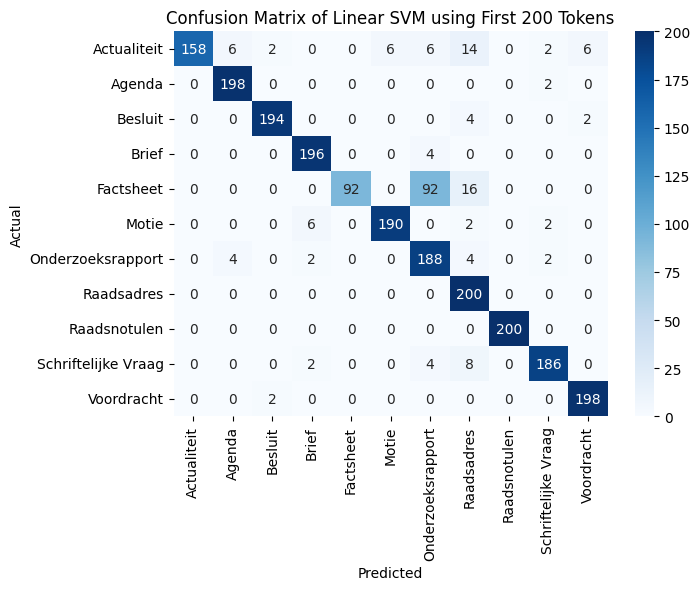

LogisticRegression_first100_last0


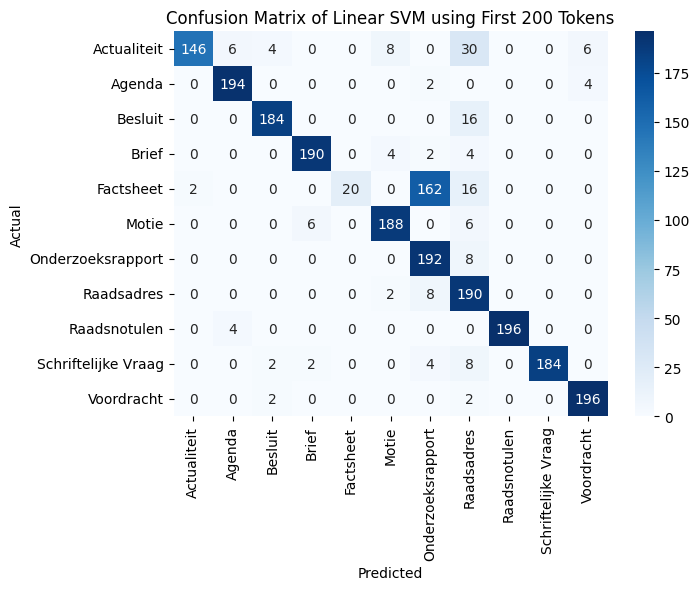

LogisticRegression_first100_last100


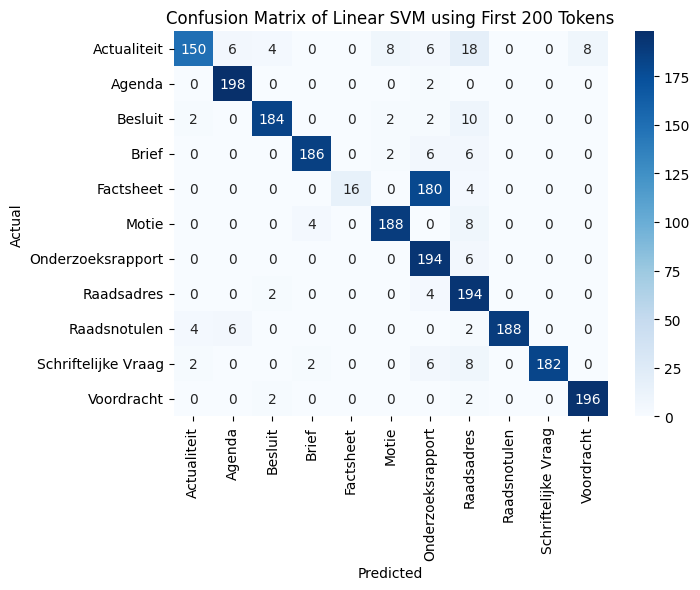

LogisticRegression_first200_last0


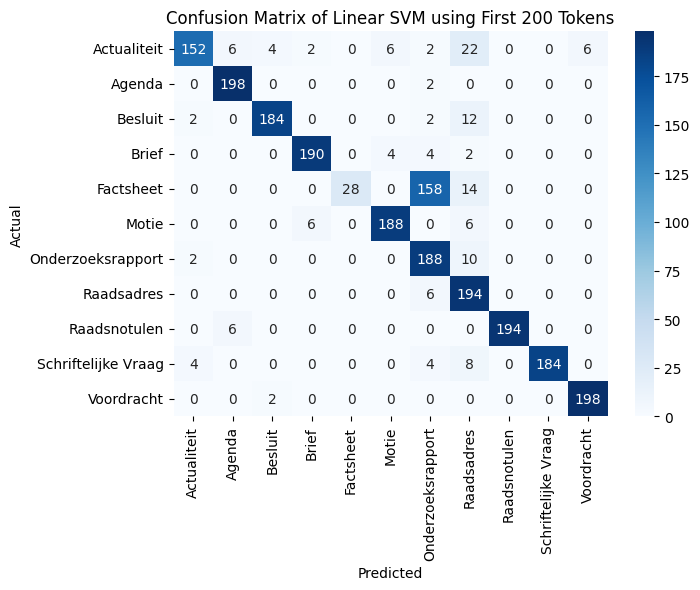

LogisticRegression_fulltext


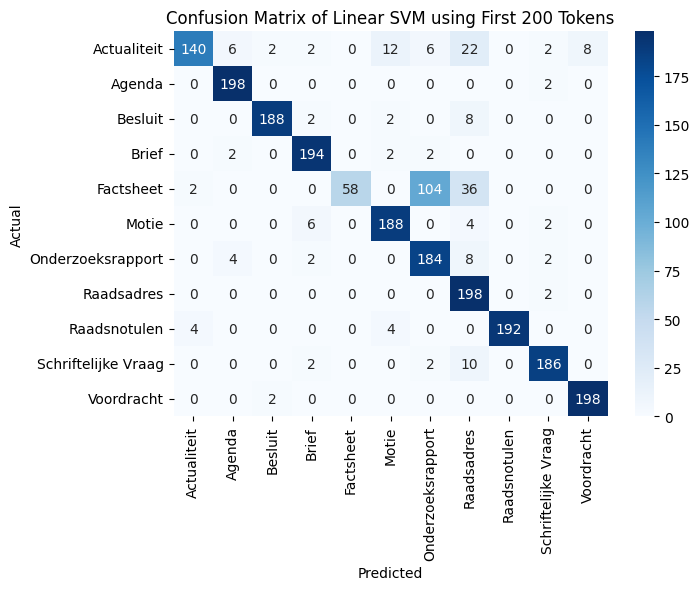

MultinomialNB_first100_last0


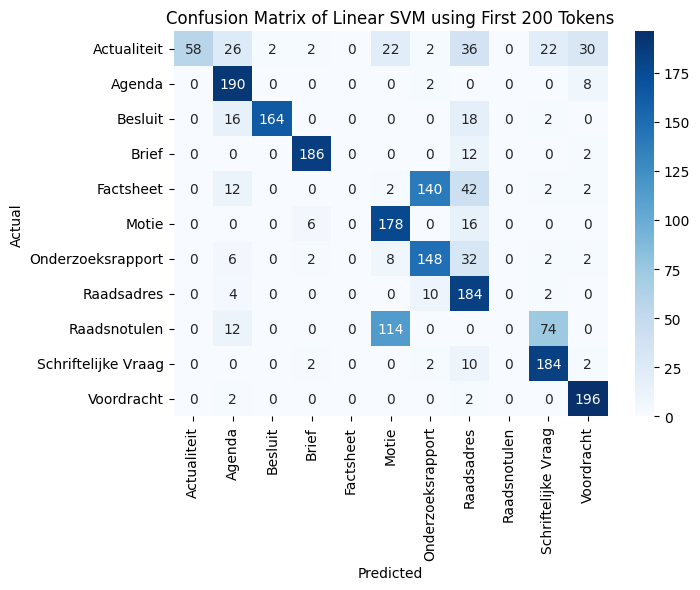

MultinomialNB_first100_last100


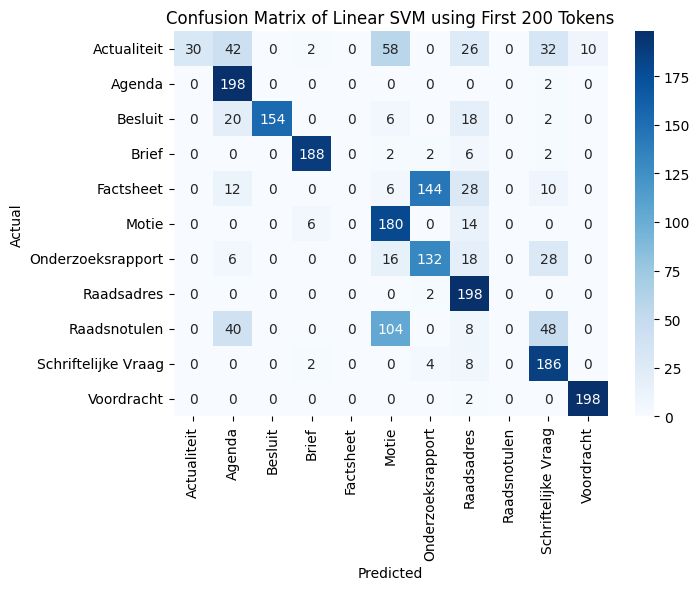

MultinomialNB_first200_last0


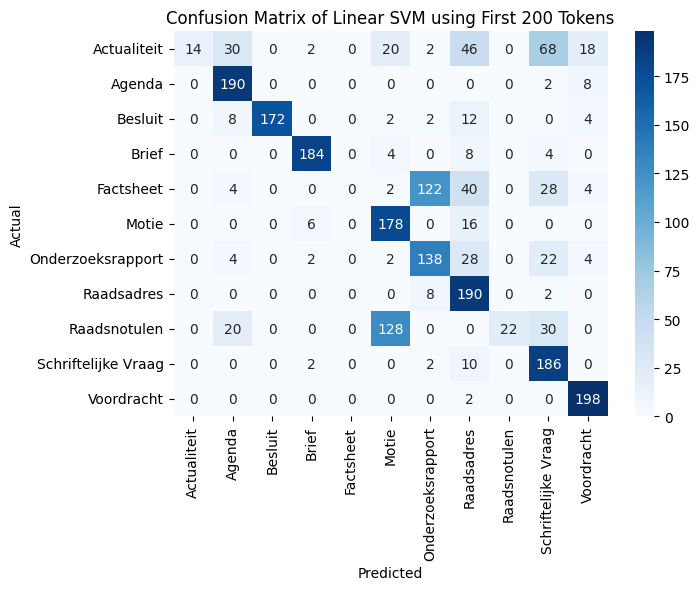

MultinomialNB_fulltext


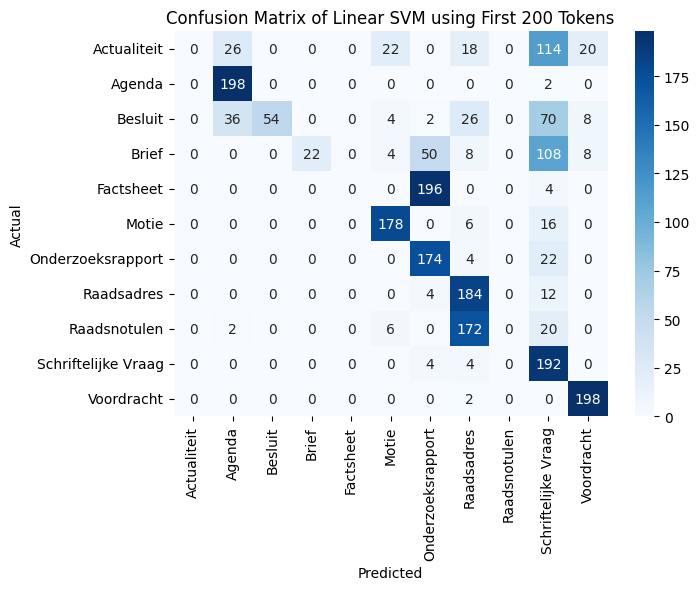

In [9]:
plot_confusion_matrix(predictions)